In [1]:
%matplotlib inline
from utils import read, createGraph, readExtraInfo, readGenre, readBirthdays, getCharacterAges
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp
import pickle
import warnings
#import community
import networkx as nx
import itertools
import scipy as sp 
import logging
from funcy import walk_values

import statsmodels.api as sm
from statsmodels.formula.api import ols

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
logging.basicConfig(format = "%(asctime)-15s %(message)s", level = logging.DEBUG)

In [3]:
th = 2
data_dir = "../data/utterances_with_charnames/*"
info_dir = "../data/charandmovie_info/"
birthdays_f = "../data/age/actor_birthdays.txt"

## Read all scripts

In [4]:
birthdays = readBirthdays(birthdays_f)

In [7]:
data = {}
for script in glob(data_dir):
    
    _, char_list, adj = read(script, threshold = th)

    extra_info = info_dir + basename(script)
    if exists(extra_info):
        genders, races, namesids, movieyear = readExtraInfo(extra_info)
        genres = readGenre(extra_info)
    else:
#         logging.warning("Info for {} not found".format(basename(script)))
#         gens = defaultdict(lambda: 'unknown')
#         races = defaultdict(lambda: 'unknown')  
        continue
        
    races = walk_values(lambda x: x.split(",")[0], races)
    ages = getCharacterAges(char_list, namesids, movieyear, birthdays)
        
        
    G = createGraph(char_list,
                    adj,
                    genders = genders,
                    races = races,
                    ages = ages)

    

    key = basename(script)

    data[key] = {}
    data[key]['graph'] = G
    data[key]['chars'] = char_list
    data[key]['genres'] = genres
    data[key]['ages'] = ages
    data[key]['races'] = races
    data[key]['year'] = movieyear
    

In [45]:
data['american_beauty.txt'];

In [9]:
np.sum([nx.number_of_nodes(d['graph']) for d in data.values()])

15133

In [10]:
types = Counter([y for x in [d['genres'] for script, d in data.items()] for y in x])
print(types)
types = list(types.keys())

Counter({'Drama': 559, 'Thriller': 368, 'Comedy': 287, 'Action': 252, 'Crime': 242, 'Romance': 194, 'Adventure': 170, 'Sci-Fi': 156, 'Mystery': 145, 'Horror': 116, 'Fantasy': 115, 'Biography': 70, 'Family': 49, 'History': 34, 'War': 34, 'Animation': 32, 'Sport': 32, 'Music': 22, 'Musical': 19, 'Western': 17, 'Short': 5, 'Film-Noir': 5})


In [11]:
races = Counter([y for x in [list(d['races'].values()) for d in data.values()] for y in x])
print(races)
races = list(races.keys())

Counter({'caucasian': 8219, 'unknown': 6750, 'african': 881, 'latino': 281, 'other': 234, 'eastasian': 137, 'nativeamerican': 77, 'asianindian': 77, 'pacificislander': 22, 'others': 12})


In [12]:
xkcd_colors = sns.xkcd_palette(["grass green", "sand", "blue", "light red", "cerulean",
                                "red", "light blue", "teal", "orange", "light green",
                                "magenta", "yellow", "sky blue", "grey", "cobalt",
                                "grass", "algae green", "coral", "cerise", "steel",
                                "hot purple", "mango", "pale lime", "rouge"])
colors = itertools.cycle(xkcd_colors)

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen (women = $30.9$%). Lets check our numbers.

In [13]:
total, males, females = 0, 0, 0
for _, d in data.items():
    G = d['graph']
    
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


total: 15133
males: 0.55%
females: 0.21%


What if we drop unknown?... shouldn't matter right?

In [14]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

males: 0.72%
females: 0.28%


# Graph analysis


# Betweeness Centrality

#### Average centrality

In [15]:
male_cent, female_cent = [], []
for script, d in data.items():
    G = d['graph']
    cents = nx.betweenness_centrality(G)
    
    male_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

/home/victor/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/victor/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
#Remove nans
male_cent, female_cent = np.array(male_cent), np.array(female_cent)
male_cent = male_cent[~np.isnan(male_cent)]
female_cent = female_cent[~np.isnan(female_cent)]

In [17]:
sp.stats.describe([y for x in [list(nx.betweenness_centrality(d['graph']).values()) for d in data.values()] for y in x])

DescribeResult(nobs=15133, minmax=(0.0, 1.0), mean=0.04559484234798223, variance=0.0087036555743516143, skewness=3.5561931822032755, kurtosis=15.501383735343612)

Just a quick note, this is a _density_, not a probability. The AUC adds up to 1. 

/home/victor/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


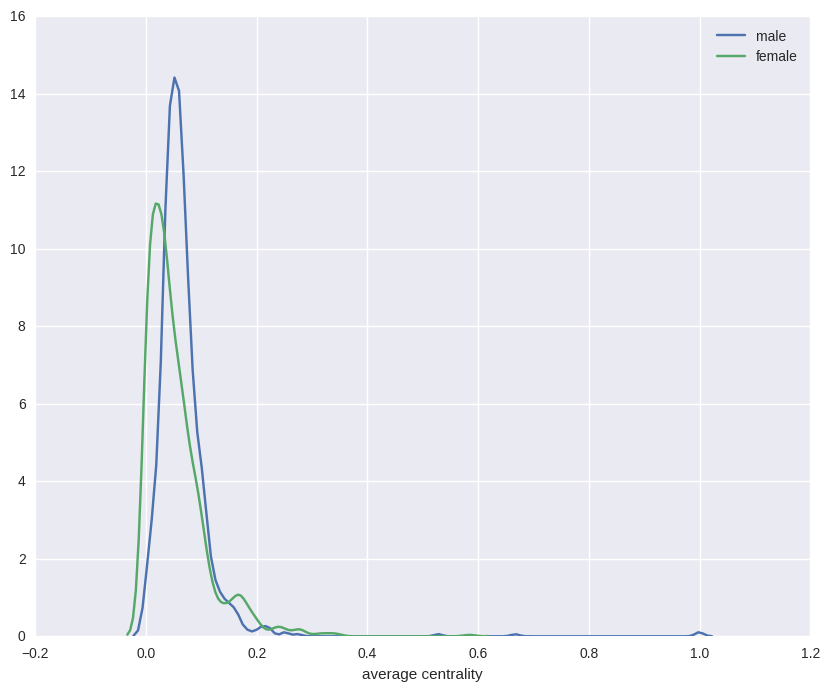

In [18]:
sns.distplot(male_cent, hist = False, label = "male");
sns.distplot(female_cent, hist = False, label = "female");
plt.legend();
plt.xlabel("average centrality");

In this case, there is a significant difference in the average centrality of male characters and female characters ($t(?) = 4.8805,\, p < 0.01$). In most of the scripts, males occupy a more central role than females.

In [19]:
sp.stats.ttest_ind(male_cent, female_cent)

Ttest_indResult(statistic=4.7163297623549516, pvalue=2.5730714959692755e-06)

## By Genre

In [20]:
res = {}
for t in types:
    male_centr, female_centr = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        centralities = nx.betweenness_centrality(G)

        male_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_centr
    res[t]['female'] = female_centr

/home/victor/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/victor/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,Fantasy,female,0.020192
1,Fantasy,female,0.034227
2,Fantasy,female,0.152020
3,Fantasy,female,0.063575
4,Fantasy,female,0.087302


In [22]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__ There is a real difference in the centrality of characters in: __

In [23]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[('Drama',
  Ttest_indResult(statistic=5.5262644731199062, pvalue=4.0836730069908048e-08)),
 ('Comedy',
  Ttest_indResult(statistic=4.9098226229261925, pvalue=1.1971133888063754e-06)),
 ('Horror',
  Ttest_indResult(statistic=-4.4777638911415734, pvalue=1.1923689840356085e-05)),
 ('Sport',
  Ttest_indResult(statistic=4.308836031933156, pvalue=6.0748376366828641e-05)),
 ('Biography',
  Ttest_indResult(statistic=3.1693058305550705, pvalue=0.0018850415732367494)),
 ('Sci-Fi',
  Ttest_indResult(statistic=2.5448253204036706, pvalue=0.011427429949245017))]

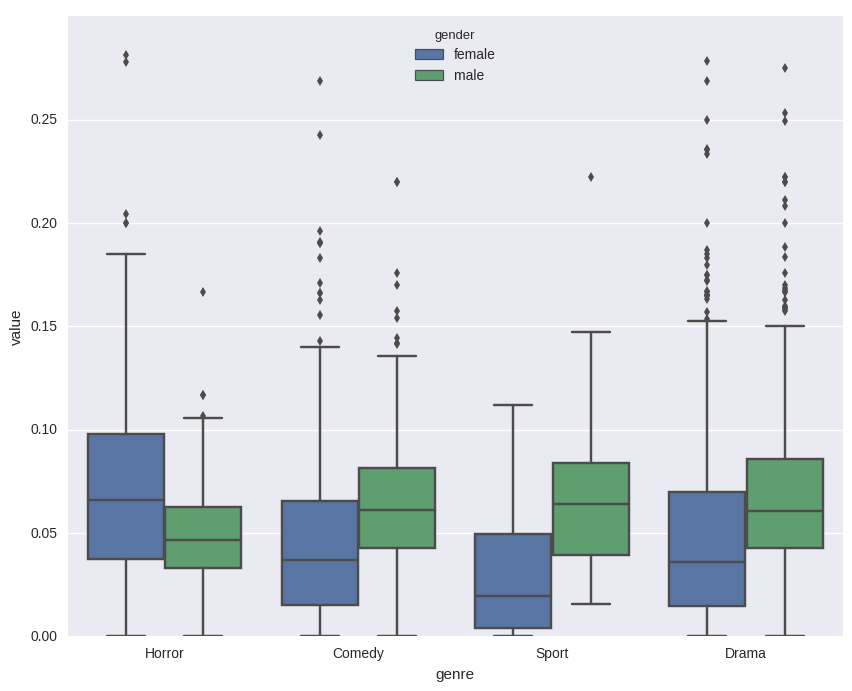

In [24]:
t = tmp[tmp.genre.isin(['Drama', 'Comedy', 'Horror', 'Sport'])]
bplt = sns.boxplot(x = 'genre', y = 'value', hue = 'gender', data = t)
bplt.axes.set_ylim([0, .3]);

In [25]:
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"].mean()
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"].mean()

    
    if male_deg < female_deg:
        print(t, male_deg, female_deg)
    

Horror 0.049621630853597644 0.07546899248775672
Western 0.04639489994866103 0.07700710935827022
Film-Noir 0.07548565604852155 0.13004612184436745


## By Race

I can either agg by race (e.g., caucassian males get more important roles) or I could agg races by gender (e.g., latino women are more demanded than latino men).

In [26]:
# Agg by race

aggByRace = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByRace.append((G.node[n]['race'], centrs[n]))
        
aggByRace = pd.DataFrame(aggByRace, columns=['race', 'value'])
aggByRace = aggByRace[aggByRace.race != 'unknown']
aggByRace.head()

,race,value
2,caucasian,0.157769
4,caucasian,0.000494
5,caucasian,0.049456
8,caucasian,0.034403
9,african,0.000659


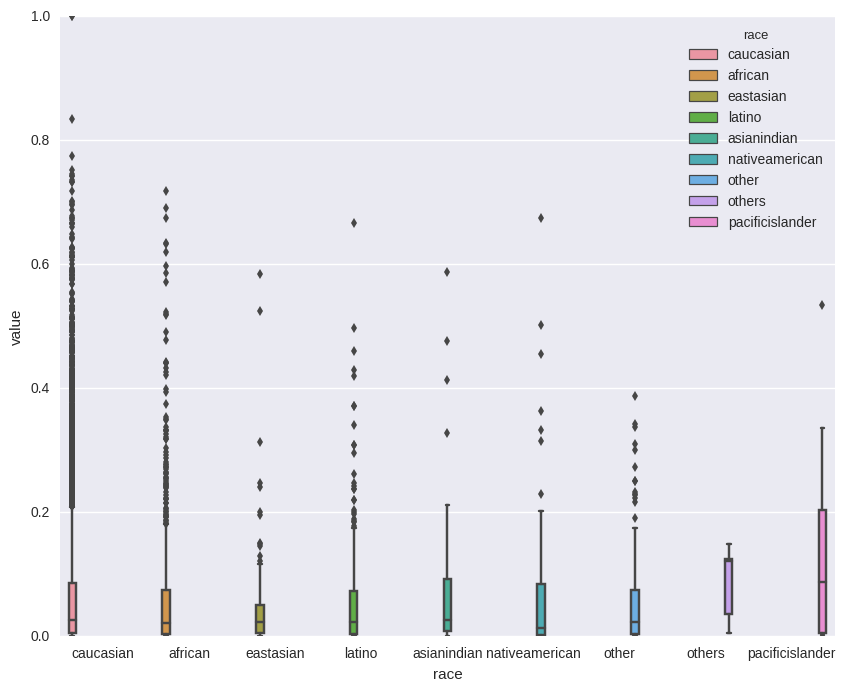

In [27]:
sns.boxplot(x = "race", y = "value", hue = "race", data = aggByRace);

In [28]:
#1-way ANOVA for differences

mod = ols('value ~ race',
                data=aggByRace).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

              sum_sq      df        F    PR(>F)
race        0.234734     8.0  2.29391  0.018832
Residual  107.112920  8374.0      NaN       NaN


Post-hoc: Find differences by comparing each two and controlling error with Benjamin-Hochberg's method

~~__TODO:__ But this doesnt matter too much~~ It Matters now...

### Agg race and gender

In [ ]:
# Agg by race & gender

aggByRaceGender = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByRaceGender.append((G.node[n]['race'], G.node[n]['gender'], centrs[n]))
        
aggByRaceGender = pd.DataFrame(aggByRaceGender, columns=['race', 'gender', 'value'])
aggByRaceGender = aggByRaceGender[aggByRaceGender.race != 'unknown']
aggByRaceGender = aggByRaceGender[aggByRaceGender.gender != 'unknown']

aggByRaceGender.head()

In [ ]:
bxplt = sns.boxplot(x = "race", y = "value", hue = "gender", data = aggByRaceGender);
bxplt.axes.set_ylim([0, .3]);

In [ ]:
latinos = aggByRaceGender[aggByRaceGender.race == "latino"]
lat_male = latinos[latinos.gender == "male"]
lat_female = latinos[latinos.gender == "female"]


sp.stats.ttest_ind(lat_male.value, lat_female.value)

In [ ]:
latinos = aggByRaceGender[aggByRaceGender.race == "caucasian"]
lat_male = latinos[latinos.gender == "male"]
lat_female = latinos[latinos.gender == "female"]


sp.stats.ttest_ind(lat_male.value, lat_female.value)

In [ ]:
np.abs(np.mean(lat_male.value) - np.mean(lat_female.value))

### By Age

In [29]:
# Agg by age

aggByAge = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByAge.append((G.node[n]['age'], centrs[n]))
        
aggByAge = pd.DataFrame(aggByAge, columns=['age', 'value'])
aggByAge = aggByAge[aggByAge.age > 0]
aggByAge.head()

,age,value
0,35,0.003096
2,25,0.157769
4,33,0.000494
5,24,0.049456
6,49,0.042964


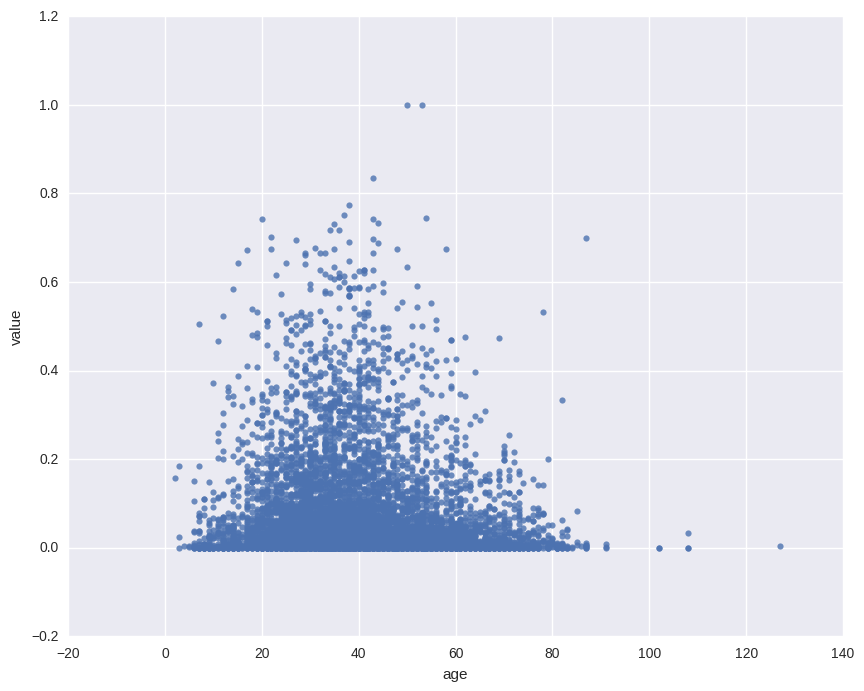

In [33]:
ax = sns.regplot(x = "age", y = "value", data = aggByAge, fit_reg = False)

### By Age and Gender

In [35]:
# Agg by age & gender

aggByAgeGender = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByAgeGender.append((G.node[n]['age'], G.node[n]['gender'], centrs[n]))
        
aggByAgeGender = pd.DataFrame(aggByAgeGender, columns=['age', 'gender', 'value'])
aggByAgeGender = aggByAgeGender[aggByAgeGender.age > 0]
aggByAgeGender = aggByAgeGender[aggByAgeGender.gender != 'unknown']

aggByAgeGender.head()

,age,gender,value
0,35,male,0.003096
2,25,female,0.157769
4,33,male,0.000494
5,24,male,0.049456
6,49,male,0.042964


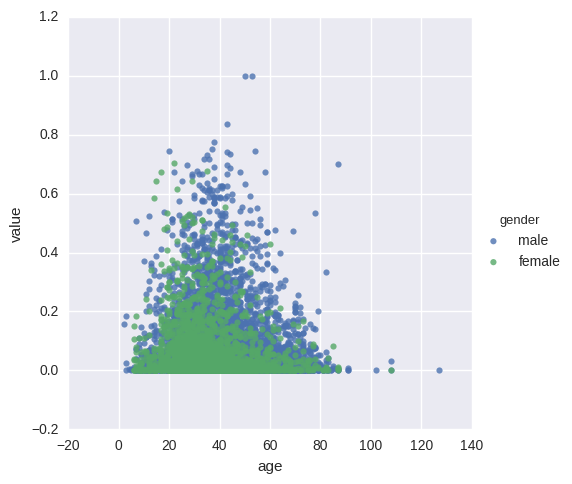

In [39]:
ax = sns.lmplot(x = "age", y = "value", hue = "gender", data = aggByAgeGender, fit_reg = False)

In [42]:
ages_women = aggByAgeGender.ix[aggByAgeGender.gender == "female", "value"]
ages_male = aggByAgeGender.ix[aggByAgeGender.gender == "male", "value"]

#Remove nans
male_deg, female_deg = np.array(ages_male), np.array(ages_women)
male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]

ttest = sp.stats.ttest_ind(male_deg, female_deg)
ttest

Ttest_indResult(statistic=3.2884362285136306, pvalue=0.0010109850086406004)

### By Age and Race

In [48]:
# Agg by age & gender

aggByAgeRace = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByAgeRace.append((G.node[n]['age'], G.node[n]['race'], centrs[n]))
        
aggByAgeRace = pd.DataFrame(aggByAgeRace, columns=['age', 'race', 'value'])
aggByAgeRace = aggByAgeRace[aggByAgeRace.age > 0]
aggByAgeRace = aggByAgeRace[aggByAgeRace.race != 'unknown']

aggByAgeRace['ageGrp'] = aggByAgeRace.age.apply(lambda x: (x//10) * 10)

aggByAgeRace.head()

,age,race,value,ageGrp
2,25,caucasian,0.157769,20
4,33,caucasian,0.000494,30
5,24,caucasian,0.049456,20
8,61,caucasian,0.034403,60
9,33,african,0.000659,30


In [59]:
#2-way ANOVA for differences

mod = ols('value ~ race + ageGrp + race:ageGrp',
                data=aggByAgeRace).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                 sum_sq      df          F        PR(>F)
race           0.277025     7.0   3.045115  3.358571e-03
ageGrp         0.653414     1.0  50.277240  1.449386e-12
race:ageGrp    0.009442     7.0   0.103786  9.981221e-01
Residual     103.306924  7949.0        NaN           NaN


In [67]:
aggByAgeRace.groupby(["race", "ageGrp"]).apply(np.mean).drop("ageGrp", 1)

age     value
race            ageGrp                     
african         0        9.000000  0.008902
                10      15.272727  0.036081
                20      26.057143  0.071729
                30      34.970833  0.074826
                40      44.254545  0.075177
                50      54.043011  0.054176
                60      63.066667  0.024797
                70      73.444444  0.041203
asianindian     10      17.000000  0.173630
                20      26.043478  0.069728
                30      34.833333  0.079003
                40      43.250000  0.079616
                50      53.900000  0.047306
                60      67.000000  0.152306
caucasian       0        7.523810  0.060829
                10      15.513011  0.087839
                20      25.391304  0.076485
                30      34.540391  0.082214
                40      44.167100  0.079405
                50      53.954955  0.062077
                60      63.865707  0.047875
                70      73.279793  0.040788
                80      83.108108  0.040416
eastasian       10      15.600000  0.247607
                20      26.000000  0.034118
                30      34.266667  0.048545
                40      43.750000  0.032957
                50      53.600000  0.109082
                60      65.500000  0.026776
                70      74.000000  0.022238
latino          0        8.000000  0.018974
                10      17.400000  0.057419
                20      25.770492  0.064454
                30      33.679487  0.083330
                40      44.342857  0.041495
                50      51.941176  0.034677
                60      63.555556  0.061872
                70      75.666667  0.006282
nativeamerican  10      12.000000  0.137403
                20      25.260870  0.064210
                30      34.238095  0.096013
                40      46.142857  0.077918
                50      55.000000  0.002489
                60      61.500000  0.028685
other           0        8.000000  0.014203
                10      15.916667  0.069580
                20      25.242857  0.058624
                30      33.523810  0.061164
                40      44.030303  0.037321
                50      52.777778  0.025530
                60      66.250000  0.042918
                80      80.000000  0.004274
pacificislander 30      33.375000  0.140285
                40      44.166667  0.151579